# Deep Learning :  Image Classification via Self-Supervised Contrastive Learning with NNCLR!
---
---
### By - Anisha Katiyar

## Introduction
---

### Self-supervised learning

Self-supervised representation learning aims to obtain robust representations of samples
from raw data without expensive labels or annotations. Early methods in this field
focused on defining pretraining tasks which involved a surrogate task on a domain with ample
weak supervision labels. Encoders trained to solve such tasks are expected to
learn general features that might be useful for other downstream tasks requiring
expensive annotations like image classification.

### Contrastive Learning

A broad category of self-supervised learning techniques are those that use *contrastive
losses*, which have been used in a wide range of computer vision applications like image similarity,dimensionality reduction
and face verification/identification.
These methods learn a latent space that clusters positive samples together while
pushing apart negative samples.

### NNCLR

Here, we implement NNCLR as proposed in the paper
[With a Little Help from My Friends: Nearest-Neighbor Contrastive Learning of Visual Representations](https://arxiv.org/abs/2104.14548),
by Google Research and DeepMind.

NNCLR learns self-supervised representations that go beyond single-instance positives, which
allows for learning better features that are invariant to different viewpoints, deformations,
and even intra-class variations.
Clustering based methods offer a great approach to go beyond single instance positives,
but assuming the entire cluster to be positives could hurt performance due to early
over-generalization. Instead, NNCLR uses nearest neighbors in the learned representation
space as positives.
In addition, NNCLR increases the performance of existing contrastive learning methods like SimCLR and reduces the reliance of self-supervised methods on data augmentation strategies.

Shown below is a great visualization by the paper authors showing how NNCLR builds on ideas from SimCLR:

![](https://i.imgur.com/p2DbZJJ.png)

We can see that SimCLR uses two views of the same image as the positive pair. These two
views, which are produced using random data augmentations, are fed through an encoder to
obtain the positive embedding pair, we end up using two augmentations. NNCLR instead
keeps a _support set_ of embeddings representing the full data distribution, and forms
the positive pairs using nearest-neighbours. A support set is used as memory during
training, similar to a queue i.e. first-in-first-out.

In [1]:
!pip install tensorflow-datasets

## Importing Necessary Libraries
---

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image
import tensorflow_datasets as tfds
from tensorflow.keras import layers

## Listing Hyperparameters
---

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
shuffle_buffer = 5000
# The below two values are taken from https://www.tensorflow.org/datasets/catalog/stl10
labelled_train_images = 5000
unlabelled_images = 100000

temperature = 0.1
queue_size = 10000
contrastive_augmenter = {
    "brightness": 0.5,
    "name": "contrastive_augmenter",
    "scale": (0.2, 1.0),
}
classification_augmenter = {
    "brightness": 0.2,
    "name": "classification_augmenter",
    "scale": (0.5, 1.0),
}
input_shape = (96, 96, 3)
width = 128
num_epochs = 25
steps_per_epoch = 200

## Load the Dataset

We load the [STL-10](http://ai.stanford.edu/~acoates/stl10/) dataset from
TensorFlow Datasets, an image recognition dataset for developing unsupervised
feature learning, deep learning, self-taught learning algorithms. It is inspired by the
CIFAR-10 dataset, with some modifications.

---

> So this dataset has 10 classes : airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.

> The Images are 96x96 pixels, in color.


> It contains 500 training images (10 pre-defined folds), 800 test images per class.

> It also contains 100000 unlabeled images for unsupervised learning. These examples are extracted from a similar but broader distribution of images. For instance, it contains other types of animals (bears, rabbits, etc.) and vehicles (trains, buses, etc.) in addition to the ones in the labeled set.

In [4]:
dataset_name = "stl10"


def prepare_dataset():
    unlabeled_batch_size = unlabelled_images // steps_per_epoch
    labeled_batch_size = labelled_train_images // steps_per_epoch
    batch_size = unlabeled_batch_size + labeled_batch_size

    unlabeled_train_dataset = (
        tfds.load(
            dataset_name, split="unlabelled", as_supervised=True, shuffle_files=True
        )
        .shuffle(buffer_size=shuffle_buffer)
        .batch(unlabeled_batch_size, drop_remainder=True)
    )
    labeled_train_dataset = (
        tfds.load(dataset_name, split="train", as_supervised=True, shuffle_files=True)
        .shuffle(buffer_size=shuffle_buffer)
        .batch(labeled_batch_size, drop_remainder=True)
    )
    test_dataset = (
        tfds.load(dataset_name, split="test", as_supervised=True)
        .batch(batch_size)
        .prefetch(buffer_size=AUTOTUNE)
    )
    train_dataset = tf.data.Dataset.zip(
        (unlabeled_train_dataset, labeled_train_dataset)
    ).prefetch(buffer_size=AUTOTUNE)

    return batch_size, train_dataset, labeled_train_dataset, test_dataset


batch_size, train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/1.0.0.incomplete2V4MWP/stl10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/1.0.0.incomplete2V4MWP/stl10-test.tfrecord*...:   0%|          | 0/8…

Generating unlabelled examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/1.0.0.incomplete2V4MWP/stl10-unlabelled.tfrecord*...:   0%|         …

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


In [23]:

# def display_images(dataset, categories, num_images=10):
#     for category in categories:
#         images = dataset.filter(lambda x, y: tf.equal(tf.cast(y, tf.uint8), category)).take(num_images)

#         fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

#         # Convert images to uint8 format and scale values to [0, 255].
#         for i, (image, label) in enumerate(images):
#             image = tf.cast((image * 255.0) // 1.0, tf.uint8).numpy()
#             axs[i].imshow(image)
#             axs[i].set_title(label.numpy().decode())
#             axs[i].axis('off')

#         plt.suptitle(category)
#         plt.show()

# # For the given example, you're displaying images of the 'airplane' category.
# # categories = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
# categories = ['airplane']
# display_images(train_dataset, categories, num_images=5)


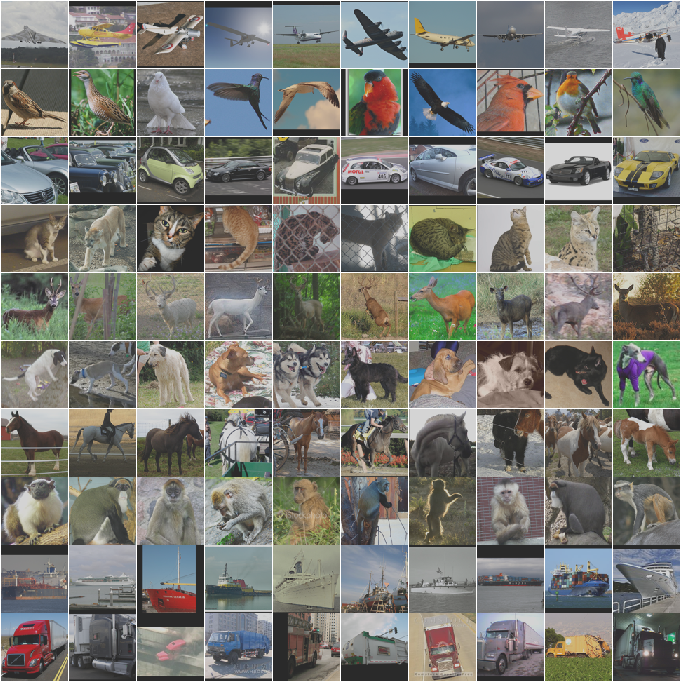

In [22]:
Image('Dataset.png')

In [14]:
if tf.test.is_gpu_available():
  print("GPU acceleration is available.")
else:
  print("GPU acceleration is not available.")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU acceleration is available.


### Creating Random Resized Crops

In [24]:

class RandomResizedCrop(layers.Layer):
    def __init__(self, scale, ratio):
        super().__init__()
        self.scale = scale
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        random_scales = tf.random.uniform((batch_size,), self.scale[0], self.scale[1])
        random_ratios = tf.exp(
            tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
        )

        new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
        new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)
        height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
        width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

        bounding_boxes = tf.stack(
            [
                height_offsets,
                width_offsets,
                height_offsets + new_heights,
                width_offsets + new_widths,
            ],
            axis=1,
        )
        images = tf.image.crop_and_resize(
            images, bounding_boxes, tf.range(batch_size), (height, width)
        )
        return images


### Creating Random Brightness

In [25]:

class RandomBrightness(layers.Layer):
    def __init__(self, brightness):
        super().__init__()
        self.brightness = brightness

    def blend(self, images_1, images_2, ratios):
        return tf.clip_by_value(ratios * images_1 + (1.0 - ratios) * images_2, 0, 1)

    def random_brightness(self, images):
        # random interpolation/extrapolation between the image and darkness
        return self.blend(
            images,
            0,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.brightness, 1 + self.brightness
            ),
        )

    def call(self, images):
        images = self.random_brightness(images)
        return images


### Preparing the augmentation module

In [26]:

def augmenter(brightness, name, scale):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            RandomResizedCrop(scale=scale, ratio=(3 / 4, 4 / 3)),
            RandomBrightness(brightness=brightness),
        ],
        name=name,
    )


### Making of the Encoder Architecture

In the original paper, the authors use ResNet-50 as the encoder architecture and spatially average the outputs of ResNet-50. However, to minimize training time, we just use four convolutional layers.

In [27]:

def encoder():
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )


## The NNCLR model for contrastive pre-training

We train an encoder on unlabeled images with a contrastive loss. A nonlinear projection
head is attached to the top of the encoder, as it improves the quality of representations
of the encoder.

In [28]:

class NNCLR(keras.Model):
    def __init__(
        self, temperature, queue_size,
    ):
        super().__init__()
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.correlation_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_augmenter = augmenter(**contrastive_augmenter)
        self.classification_augmenter = augmenter(**classification_augmenter)
        self.encoder = encoder()
        self.projection_head = keras.Sequential(
            [
                layers.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(10)], name="linear_probe"
        )
        self.temperature = temperature

        feature_dimensions = self.encoder.output_shape[1]
        self.feature_queue = tf.Variable(
            tf.math.l2_normalize(
                tf.random.normal(shape=(queue_size, feature_dimensions)), axis=1
            ),
            trainable=False,
        )

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)
        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

    def nearest_neighbour(self, projections):
        support_similarities = tf.matmul(
            projections, self.feature_queue, transpose_b=True
        )
        nn_projections = tf.gather(
            self.feature_queue, tf.argmax(support_similarities, axis=1), axis=0
        )
        return projections + tf.stop_gradient(nn_projections - projections)

    def update_contrastive_accuracy(self, features_1, features_2):
        features_1 = tf.math.l2_normalize(features_1, axis=1)
        features_2 = tf.math.l2_normalize(features_2, axis=1)
        similarities = tf.matmul(features_1, features_2, transpose_b=True)

        batch_size = tf.shape(features_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(
            tf.concat([contrastive_labels, contrastive_labels], axis=0),
            tf.concat([similarities, tf.transpose(similarities)], axis=0),
        )

    def update_correlation_accuracy(self, features_1, features_2):
        features_1 = (
            features_1 - tf.reduce_mean(features_1, axis=0)
        ) / tf.math.reduce_std(features_1, axis=0)
        features_2 = (
            features_2 - tf.reduce_mean(features_2, axis=0)
        ) / tf.math.reduce_std(features_2, axis=0)

        batch_size = tf.shape(features_1, out_type=tf.float32)[0]
        cross_correlation = (
            tf.matmul(features_1, features_2, transpose_a=True) / batch_size
        )

        feature_dim = tf.shape(features_1)[1]
        correlation_labels = tf.range(feature_dim)
        self.correlation_accuracy.update_state(
            tf.concat([correlation_labels, correlation_labels], axis=0),
            tf.concat([cross_correlation, tf.transpose(cross_correlation)], axis=0),
        )

    def contrastive_loss(self, projections_1, projections_2):
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)

        similarities_1_2_1 = (
            tf.matmul(
                self.nearest_neighbour(projections_1), projections_2, transpose_b=True
            )
            / self.temperature
        )
        similarities_1_2_2 = (
            tf.matmul(
                projections_2, self.nearest_neighbour(projections_1), transpose_b=True
            )
            / self.temperature
        )

        similarities_2_1_1 = (
            tf.matmul(
                self.nearest_neighbour(projections_2), projections_1, transpose_b=True
            )
            / self.temperature
        )
        similarities_2_1_2 = (
            tf.matmul(
                projections_1, self.nearest_neighbour(projections_2), transpose_b=True
            )
            / self.temperature
        )

        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        loss = keras.losses.sparse_categorical_crossentropy(
            tf.concat(
                [
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels,
                ],
                axis=0,
            ),
            tf.concat(
                [
                    similarities_1_2_1,
                    similarities_1_2_2,
                    similarities_2_1_1,
                    similarities_2_1_2,
                ],
                axis=0,
            ),
            from_logits=True,
        )

        self.feature_queue.assign(
            tf.concat([projections_1, self.feature_queue[:-batch_size]], axis=0)
        )
        return loss

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        augmented_images_1 = self.contrastive_augmenter(images)
        augmented_images_2 = self.contrastive_augmenter(images)

        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.update_contrastive_accuracy(features_1, features_2)
        self.update_correlation_accuracy(features_1, features_2)
        preprocessed_images = self.classification_augmenter(labeled_images)

        with tf.GradientTape() as tape:
            features = self.encoder(preprocessed_images)
            class_logits = self.linear_probe(features)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_accuracy.update_state(labels, class_logits)

        return {
            "c_loss": contrastive_loss,
            "c_acc": self.contrastive_accuracy.result(),
            "r_acc": self.correlation_accuracy.result(),
            "p_loss": probe_loss,
            "p_acc": self.probe_accuracy.result(),
        }

    def test_step(self, data):
        labeled_images, labels = data

        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)

        self.probe_accuracy.update_state(labels, class_logits)
        return {"p_loss": probe_loss, "p_acc": self.probe_accuracy.result()}


In [29]:
model = NNCLR(temperature=temperature, queue_size=queue_size)
model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)
pretrain_history = model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)

Epoch 1/25
200/200 [==============================] - 93s 364ms/step - c_loss: 3.2797 - c_acc: 0.4050 - r_acc: 0.4935 - p_loss: 2.2117 - p_acc: 0.1444 - val_p_loss: 2.1144 - val_p_acc: 0.2160
Epoch 2/25
200/200 [==============================] - 78s 366ms/step - c_loss: 2.1761 - c_acc: 0.6912 - r_acc: 0.5547 - p_loss: 2.0532 - p_acc: 0.2263 - val_p_loss: 1.9820 - val_p_acc: 0.2842
Epoch 3/25
200/200 [==============================] - 77s 362ms/step - c_loss: 1.8627 - c_acc: 0.7710 - r_acc: 0.5529 - p_loss: 1.9377 - p_acc: 0.2920 - val_p_loss: 1.9355 - val_p_acc: 0.3081
Epoch 4/25
200/200 [==============================] - 75s 357ms/step - c_loss: 1.7212 - c_acc: 0.8070 - r_acc: 0.5470 - p_loss: 1.8655 - p_acc: 0.3284 - val_p_loss: 1.8442 - val_p_acc: 0.3394
Epoch 5/25
200/200 [==============================] - 77s 365ms/step - c_loss: 1.6167 - c_acc: 0.8338 - r_acc: 0.5480 - p_loss: 1.8164 - p_acc: 0.3233 - val_p_loss: 1.8312 - val_p_acc: 0.3388
Epoch 6/25
200/200 [====================

## Evaluating my Model
---

Using the backbone just trained, it is Implemented for Image Classification as its downstream task.

In [30]:
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        augmenter(**classification_augmenter),
        model.encoder,
        layers.Dense(10),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)

Epoch 1/25
200/200 [==============================] - 11s 26ms/step - loss: 1.9780 - acc: 0.2580 - val_loss: 1.7066 - val_acc: 0.3405
Epoch 2/25
200/200 [==============================] - 7s 28ms/step - loss: 1.6114 - acc: 0.3906 - val_loss: 1.6509 - val_acc: 0.3963
Epoch 3/25
200/200 [==============================] - 7s 25ms/step - loss: 1.4996 - acc: 0.4486 - val_loss: 1.4427 - val_acc: 0.4538
Epoch 4/25
200/200 [==============================] - 10s 36ms/step - loss: 1.4235 - acc: 0.4678 - val_loss: 1.4223 - val_acc: 0.4581
Epoch 5/25
200/200 [==============================] - 9s 35ms/step - loss: 1.3416 - acc: 0.5004 - val_loss: 1.3625 - val_acc: 0.4941
Epoch 6/25
200/200 [==============================] - 9s 36ms/step - loss: 1.3037 - acc: 0.5106 - val_loss: 1.3345 - val_acc: 0.5052
Epoch 7/25
200/200 [==============================] - 7s 25ms/step - loss: 1.2110 - acc: 0.5504 - val_loss: 1.2748 - val_acc: 0.5385
Epoch 8/25
200/200 [==============================] - 9s 37ms/step 

In [41]:
# # Make predictions on the test set.
# predictions = finetuning_model.predict(test_dataset)

# # Get the predicted labels.
# predicted_labels = np.argmax(predictions, axis=1)

# # Get the true labels.
# true_labels = []
# for x, y in test_dataset.as_numpy_iterator():
#     true_labels.append(y)

# # Display the image classification results.
# fig, axs = plt.subplots(5, 5, figsize=(15, 15))
# for i in range(25):
#     axs[i // 5, i % 5].imshow(test_dataset[i])
#     axs[i // 5, i % 5].set_title(f'True: {true_labels[i]} | Predicted: {predicted_labels[i]}')
#     axs[i // 5, i % 5].axis('off')

# plt.suptitle('Image Classification Results')
# plt.show()

## THE END
---